In [1]:
import pandas as pd
from IPython.display import display
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import mannwhitneyu
import gc
import numpy as np
import ast
import json
import joblib
import tensorflow as tf
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
data_path = "C:\\Users\\User\\Downloads\\"

In [3]:
df1 = pd.read_csv(f"{data_path}2019-Oct.csv", usecols=['event_time', 'event_type', 'product_id', 'brand', 'category_code', 'price', 'user_id', 'user_session'])
df2 = pd.read_csv(f"{data_path}2019-Nov.csv", usecols=['event_time', 'event_type', 'product_id', 'brand', 'category_code', 'price', 'user_id', 'user_session'])
df = pd.concat([df1, df2])
del df1, df2
gc.collect()

0

In [4]:
df['category_code'] = df['category_code'].astype('category')
df['category_code'] = df['category_code'].cat.add_categories('unknown.')
df['category_code'].fillna('unknown.', inplace=True)

df['general_category'] = df['category_code'].apply(lambda x: x.split('.')[0])

In [5]:
df['user_session'] = df['user_session'].astype('category').cat.codes

In [6]:
# datetime 처리
df['event_time'] = pd.to_datetime(df['event_time'])
df['date'] = df['event_time'].dt.date

# 사용자별, 시간순 정렬
df = df.sort_values(['user_id', 'event_time'])

# 구매 발생 플래그
df['is_purchase'] = df['event_type'] == 'purchase'

# 하루 단위 기준 세션 초기화
df['daily_session'] = df['user_id'].astype(str) + '_' + df['date'].astype(str)

# 구매 발생 시 세션 쪼개기: 구매 이후는 새로운 세션으로
def split_on_purchase(group):
    session_id = []
    counter = 0
    for is_p in group['is_purchase']:
        session_id.append(counter)
        if is_p:
            counter += 1
    return session_id

# 사용자 + 날짜별로 쪼개서 세션 나누기
df['session_split_id'] = df.groupby(['user_id', 'date']).apply(split_on_purchase).explode().values

df['custom_session'] = (
    df['user_id'].astype(str) + '_' +
    df['date'].astype(str) + '_' +
    df['session_split_id'].astype(str)
)

In [7]:
# df_col : ['user_id', 'event_time', 'event_type', 'product_id', 'brand', 'category_code', 'price', 'user_session', 'is_purchase', 'daily_session', 'custom_session']
df.drop(columns=['user_session', 'is_purchase', 'daily_session', 'session_split_id'], inplace=True)
df.head(2)

,event_time,event_type,product_id,category_code,brand,price,user_id,general_category,date,custom_session
8425249,2019-11-06 06:51:52+00:00,view,26300219,unknown.,sokolov,40.54,10300217,unknown,2019-11-06,10300217_2019-11-06_0
15378293,2019-11-10 02:08:39+00:00,view,13200917,furniture.bedroom.bed,NaN,514.81,29515875,furniture,2019-11-10,29515875_2019-11-10_0


### 0/1 sampling

In [8]:
buy_sessions = df[df['event_type'] == 'purchase']['custom_session'].unique()
df['buy'] = df['custom_session'].isin(buy_sessions).astype(int)

In [9]:
buy = df[df['buy'] == 1]
df = df[df['buy'] == 0].sample(n=int(len(buy)), random_state=42)
df = pd.concat([buy, df])

In [10]:
del buy
gc.collect()

16

In [ ]:
median_price_category = df.groupby('general_category')['price'].median().to_dict()
df['relative_price'] = df['price'] / df['general_category'].map(median_price_category)
df.head(2) 

,event_time,event_type,product_id,category_code,brand,price,user_id,general_category,date,custom_session,buy,relative_price
17585804,2019-11-11 05:41:18+00:00,view,17301868,unknown.,sheba,144.14,138340325,unknown,2019-11-11,138340325_2019-11-11_0,1,1.867098
17587691,2019-11-11 05:42:24+00:00,view,17300771,unknown.,bulgari,57.72,138340325,unknown,2019-11-11,138340325_2019-11-11_0,1,0.747668


In [12]:
del median_price_category
gc.collect()

32

In [13]:
df['custom_session'] = df['custom_session'].astype('category').cat.codes

### first save

In [14]:
df.to_csv(f"{data_path}custom_session_sampled.csv", index=False)

In [15]:
df = pd.read_csv(f"{data_path}custom_session_sampled.csv")

### make log_dictionary

In [ ]:
def log_dictionary(df):
    df = df.sort_values(['user_id', 'event_time'])
    df['event_time'] = pd.to_datetime(df['event_time'])

    session_data = []

    for session, group in df.groupby('custom_session'):
        group = group.sort_values('event_time')

        times = group['event_time'].tolist()
        time_since_start = [(t - times[0]).total_seconds() for t in times]
        time_since_prev = [0] + [(times[i] - times[i-1]).total_seconds() for i in range(1, len(times))]

        events = []
        for _, row in group.iterrows():
            if row['event_type'] == 'purchase':
                continue  # 구매 제외
            
            events.append({
                "event_type": row["event_type"],
                "product_id": row["product_id"],
                "category_code": row["category_code"] if pd.notna(row["category_code"]) else "unknown.",
                "general_category": row["general_category"] if pd.notna(row["general_category"]) else "unknown",
                "brand": row["brand"] if pd.notna(row["brand"]) else "unknown",
                "price": row["price"],
                "relative_price": row["relative_price"],
                "time_since_start": time_since_start[len(events)],
                "time_since_prev": time_since_prev[len(events)]
            })

        session_data.append({
            "session": session,
            "event": events,
            "buy": int(group["buy"].max())
        })

    return pd.DataFrame(session_data)

df = log_dictionary(df)

In [17]:
def category_code(events):
    for event in events:
        if event['category_code'] == 'unknown.':
            event['category_code'] = 'unknown'
    return events

df['event'] = df['event'].apply(category_code)

In [18]:
from sklearn.preprocessing import LabelEncoder
le_event = LabelEncoder()
unique_events = ['view', 'cart', 'purchase']
le_event.fit(unique_events)
le_event.classes_

array(['cart', 'purchase', 'view'], dtype='<U8')

In [19]:
def encode_event_type(events):
    for event in events:
        event['event_type'] = le_event.transform([event['event_type']])[0]
    return events

df['event'] = df['event'].apply(encode_event_type)

### second save

In [20]:
df.to_csv(f"{data_path}custom_session_sample_oct_nov_log_dict_encoded_sampled.csv", index=False)

### 전체 파이프라인: 데이터 파싱 -> vocabs -> tf.data -> Transformer 모델 -> 학습

In [21]:
df = pd.read_csv(f"{data_path}custom_session_sample_oct_nov_log_dict_encoded_sampled.csv")
df['event'] = df['event'].apply(eval)

def parse_events(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            try:
                return json.loads(x)
            except Exception:
                return []
    elif isinstance(x, list):
        return x
    else:
        return []

df['events_parsed'] = df['event'].apply(parse_events)

print("n_sessions:", len(df))
print("example session events:", df['events_parsed'].iloc[0])


n_sessions: 8342472
example session events: [{'event_type': 2, 'product_id': 4700199, 'category_code': 'auto.accessories.videoregister', 'general_category': 'auto', 'brand': 'inspector', 'price': 175.0, 'relative_price': 1.443418013856813, 'time_since_start': 0.0, 'time_since_prev': 0}]


In [22]:
# 2) Split train/val stratified
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['buy'])


In [23]:
# 3) Build vocabs on train_df
cat_fields = ['event_type', 'category_code', 'general_category', 'brand']
num_fields = ['price', 'relative_price', 'time_since_start', 'time_since_prev']
VOCAB_SIZES = {
    'event_type': None,
    'category_code': 200,
    'general_category': None,
    'brand': 5000
}

counters = {f: Counter() for f in cat_fields}
for ev_list in train_df['events_parsed']:
    for ev in ev_list:
        for f in cat_fields:
            val = ev.get(f, 'unknown')
            if val is None or (isinstance(val, float) and np.isnan(val)):
                val = 'unknown'
            counters[f][str(val)] += 1

def build_vocab(counter, max_size=None, min_freq=1, add_oov=True):
    items = [k for k,v in counter.items() if v >= min_freq]
    items_sorted = sorted(items, key=lambda x: counter[x], reverse=True)
    if max_size:
        items_sorted = items_sorted[:max_size]
    vocab = {v: i+1 for i, v in enumerate(items_sorted)}  # reserve 0 for PAD
    if add_oov:
        vocab['<OOV>'] = len(vocab) + 1
    return vocab

vocab = {}
for f in cat_fields:
    vocab[f] = build_vocab(counters[f], max_size=VOCAB_SIZES.get(f, None))
    print(f, 'vocab_size:', len(vocab[f]))


event_type vocab_size: 3
category_code vocab_size: 131
general_category vocab_size: 15
brand vocab_size: 4140


In [24]:
# 4) fit scalers on train_df
all_nums_train = {f: [] for f in num_fields}
for ev_list in train_df['events_parsed']:
    for ev in ev_list:
        for nf in num_fields:
            val = ev.get(nf, 0.0)
            if val is None:
                val = 0.0
            all_nums_train[nf].append(float(val))

scalers = {}
for nf in num_fields:
    scaler = StandardScaler()
    vals = np.array(all_nums_train[nf]).reshape(-1,1)
    scaler.fit(vals)
    scalers[nf] = scaler


In [25]:
# 5) session_to_features
MAX_SEQ_LEN = 32

def map_cat(value, vocab_map):
    if value is None:
        return vocab_map.get('<OOV>', 1)
    s = str(value)
    if s in vocab_map:
        return vocab_map[s]
    else:
        return vocab_map.get('<OOV>', 1)

def session_to_features(ev_list):
    seq_len = min(len(ev_list), MAX_SEQ_LEN)
    cat_indices = {f: np.zeros(MAX_SEQ_LEN, dtype=np.int32) for f in cat_fields}
    num_values = np.zeros((MAX_SEQ_LEN, len(num_fields)), dtype=np.float32)
    mask = np.zeros((MAX_SEQ_LEN,), dtype=np.float32)
    for i in range(seq_len):
        ev = ev_list[-seq_len + i]
        mask[i] = 1.0
        for f in cat_fields:
            cat_indices[f][i] = map_cat(ev.get(f, 'unknown'), vocab[f])
        for j, nf in enumerate(num_fields):
            val = ev.get(nf, 0.0)
            if val is None:
                val = 0.0
            scaled = scalers[nf].transform(np.array([[float(val)]]))[0,0]
            num_values[i, j] = scaled
    return cat_indices, num_values, mask


In [26]:
# 6) transform and save (.npz)
def preprocess_and_save(df_input, filename):
    all_cat = {f: [] for f in cat_fields}
    all_num = []
    all_mask = []
    all_labels = []
    print(f"Start preprocessing {len(df_input)} sessions...")
    for i, row in df_input.iterrows():
        cat_idx, num_vals, mask = session_to_features(row['events_parsed'])
        for f in cat_fields:
            all_cat[f].append(cat_idx[f])
        all_num.append(num_vals)
        all_mask.append(mask)
        all_labels.append(row['buy'])

    # to numpy
    for f in cat_fields:
        all_cat[f] = np.array(all_cat[f], dtype=np.int32)
    all_num = np.array(all_num, dtype=np.float32)
    all_mask = np.array(all_mask, dtype=np.float32)
    all_labels = np.array(all_labels, dtype=np.float32)
    np.savez_compressed(filename, **all_cat, numeric=all_num, mask=all_mask, labels=all_labels)
    print(f"Saved preprocessed data to {filename}")

preprocess_and_save(train_df, "train_preprocessed.npz")
preprocess_and_save(val_df, "val_preprocessed.npz")

# save vocab
with open('vocab.json', 'w', encoding='utf-8') as f:
    json.dump(vocab, f, ensure_ascii=False, indent=2)

# save scaler
joblib.dump(scalers, 'scalers.pkl')


Start preprocessing 7508224 sessions...
Saved preprocessed data to train_preprocessed.npz
Start preprocessing 834248 sessions...
Saved preprocessed data to val_preprocessed.npz


['scalers.pkl']

# checkpoint

In [27]:
import pandas as pd
from IPython.display import display
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import mannwhitneyu
import gc
import numpy as np
import ast
import json
import joblib
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [28]:
# 7) Load preprocessed data and make tf.data.Dataset
cat_fields = ['event_type', 'category_code', 'general_category', 'brand']
num_fields = ['price', 'relative_price', 'time_since_start', 'time_since_prev']
MAX_SEQ_LEN = 32

# load vocab 
with open('vocab.json', 'r', encoding='utf-8') as f:
    vocab = json.load(f)

# load scaler
scalers = joblib.load('scalers.pkl')


In [29]:
def load_preprocessed_npz(filename):
    data = np.load(filename)
    features = {f: data[f] for f in cat_fields}
    features['numeric'] = data['numeric']
    features['mask'] = data['mask']
    labels = data['labels']
    return features, labels

def make_tf_dataset(features, labels, batch_size=512, shuffle=True):
    def gen():
        for i in range(len(labels)):
            feat = {f: features[f][i] for f in cat_fields}
            feat['numeric'] = features['numeric'][i]
            feat['mask'] = features['mask'][i]
            label = np.array([labels[i]], dtype=np.float32)
            yield feat, label
    output_signature = (
        {**{f: tf.TensorSpec(shape=(MAX_SEQ_LEN,), dtype=tf.int32) for f in cat_fields},
         'numeric': tf.TensorSpec(shape=(MAX_SEQ_LEN, len(num_fields)), dtype=tf.float32),
         'mask': tf.TensorSpec(shape=(MAX_SEQ_LEN,), dtype=tf.float32)},
        tf.TensorSpec(shape=(1,), dtype=tf.float32)
    )
    ds = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_features, train_labels = load_preprocessed_npz("train_preprocessed.npz")
val_features, val_labels = load_preprocessed_npz("val_preprocessed.npz")

train_ds = make_tf_dataset(train_features, train_labels, shuffle=True)
val_ds = make_tf_dataset(val_features, val_labels, shuffle=False)

In [30]:
# 8) Model building
EMBED_DIM = 64
num_heads = 4
mlp_dim = EMBED_DIM * num_heads
cat_emb_layers = {}
for f in cat_fields:
    vocab_size = len(vocab[f]) + 1
    cat_emb_layers[f] = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=EMBED_DIM, mask_zero=True, name=f'emb_{f}')

pos_emb = tf.keras.layers.Embedding(input_dim=MAX_SEQ_LEN, output_dim=EMBED_DIM, name='pos_emb')

class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads, mlp_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout
        
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(mlp_dim, activation='relu'),
            tf.keras.layers.Dense(dim),
        ])
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout2 = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask=None, training=False):
        attn_mask = None
        if mask is not None:
            attn_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.bool)
        attn_out = self.mha(x, x, attention_mask=attn_mask)
        attn_out = self.dropout1(attn_out, training=training)
        out1 = self.norm1(x + attn_out)
        ff = self.ffn(out1)
        ff = self.dropout2(ff, training=training)
        out2 = self.norm2(out1 + ff)
        return out2
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "dim": self.dim,
            "num_heads": self.num_heads,
            "mlp_dim": self.mlp_dim,
            "dropout": self.dropout,
        })
        return config 

def build_model():
    inputs = {f: tf.keras.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name=f) for f in cat_fields}
    inputs['numeric'] = tf.keras.Input(shape=(MAX_SEQ_LEN, len(num_fields)), dtype=tf.float32, name='numeric')
    inputs['mask'] = tf.keras.Input(shape=(MAX_SEQ_LEN,), dtype=tf.float32, name='mask')

    emb_list = []
    for f in cat_fields:
        e = cat_emb_layers[f](inputs[f])
        emb_list.append(e)
    numeric_proj = tf.keras.layers.Dense(EMBED_DIM)(inputs['numeric'])
    emb_list.append(numeric_proj)

    x = tf.keras.layers.Add()(emb_list)
    positions = tf.range(start=0, limit=MAX_SEQ_LEN, delta=1)
    pos_embeddings = pos_emb(positions)
    x = x + pos_embeddings

    mask = inputs['mask']
    for _ in range(3):
        x = TransformerEncoderBlock(dim=EMBED_DIM, num_heads=num_heads, mlp_dim=mlp_dim)(x, mask=mask)

    mask_expanded = tf.expand_dims(mask, axis=-1)
    x_masked = x * mask_expanded
    sum_x = tf.reduce_sum(x_masked, axis=1)
    lengths = tf.reduce_sum(mask_expanded, axis=1)
    pooled = sum_x / (lengths + 1e-6)

    h = tf.keras.layers.Dense(64, activation='relu')(pooled)
    h = tf.keras.layers.Dropout(0.3)(h)
    out = tf.keras.layers.Dense(1, activation='sigmoid', name='buy_prob')(h)

    model = tf.keras.Model(inputs=inputs, outputs=out)
    return model

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.BinaryAccuracy(name='acc')])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 event_type (InputLayer)        [(None, 32)]         0           []                               
                                                                                                  
 category_code (InputLayer)     [(None, 32)]         0           []                               
                                                                                                  
 general_category (InputLayer)  [(None, 32)]         0           []                               
                                                                                                  
 brand (InputLayer)             [(None, 32)]         0           []                               
                                                                                              

In [ ]:
# 9) Train
labels = train_labels
pos = labels.sum()
neg = len(labels) - pos
class_weight = {0: 1.0, 1: (neg / (pos + 1e-6))}

early_stop = EarlyStopping(monitor='val_auc', patience=2, restore_best_weights=True, min_delta=0.001)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_auc', save_best_only=True, mode='max')

epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, class_weight=class_weight, callbacks=[early_stop, checkpoint])


Epoch 1/20
14665/14665 [==============================] - 828s 56ms/step - loss: 0.5081 - auc: 0.9235 - acc: 0.9164 - val_loss: 0.2625 - val_auc: 0.9342 - val_acc: 0.9260
Epoch 2/20
14665/14665 [==============================] - 836s 57ms/step - loss: 0.4708 - auc: 0.9337 - acc: 0.9239 - val_loss: 0.2525 - val_auc: 0.9376 - val_acc: 0.9280
Epoch 3/20
14665/14665 [==============================] - 823s 56ms/step - loss: 0.4599 - auc: 0.9367 - acc: 0.9255 - val_loss: 0.2600 - val_auc: 0.9393 - val_acc: 0.9253
Epoch 4/20
14665/14665 [==============================] - 833s 57ms/step - loss: 0.4534 - auc: 0.9385 - acc: 0.9265 - val_loss: 0.2589 - val_auc: 0.9403 - val_acc: 0.9254
Epoch 5/20
14665/14665 [==============================] - 848s 58ms/step - loss: 0.4494 - auc: 0.9396 - acc: 0.9273 - val_loss: 0.2475 - val_auc: 0.9410 - val_acc: 0.9290
Epoch 6/20
14665/14665 [==============================] - 824s 56ms/step - loss: 0.4462 - auc: 0.9405 - acc: 0.9277 - val_loss: 0.2432 - val_auc:

In [ ]:
# 10) evaluate
from tensorflow.keras.models import load_model

loaded_model = load_model("best_model.keras", custom_objects={"TransformerEncoderBlock": TransformerEncoderBlock})

In [ ]:

from sklearn.metrics import confusion_matrix, classification_report

threshold = 0.5
y_true = val_labels
y_pred = (loaded_model.predict(val_ds) > threshold).astype(int).flatten()

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


649/649 [==============================] - 29s 45ms/step
[[160547   5432]
 [ 21423 144556]]
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92    165979
         1.0       0.96      0.87      0.92    165979

    accuracy                           0.92    331958
   macro avg       0.92      0.92      0.92    331958
weighted avg       0.92      0.92      0.92    331958



649/649 [==============================] - 30s 46ms/step


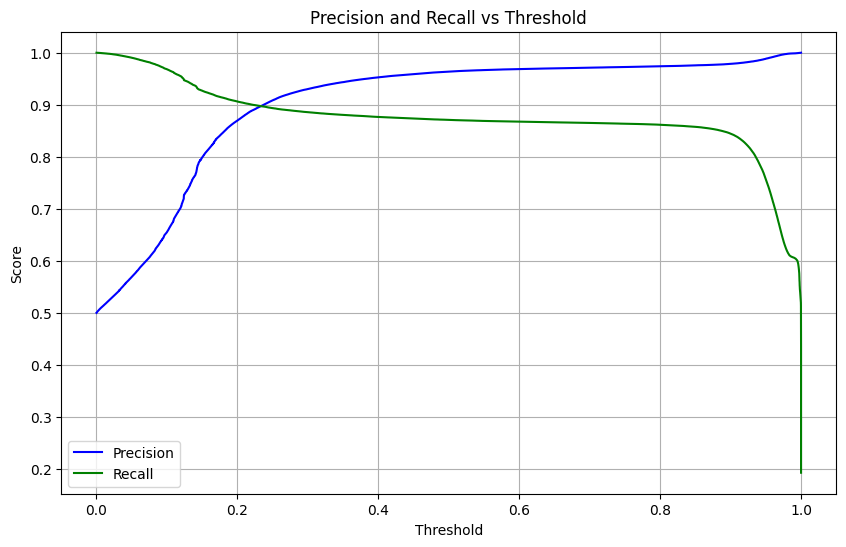

In [ ]:
from sklearn.metrics import precision_recall_curve

# 예측 확률
y_probs = loaded_model.predict(val_ds)  # ← val_ds는 y_true 포함되어 있어야 함
y_probs = y_probs.ravel()  # (n, 1) → (n,)

# precision, recall, threshold 계산
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 11) Evaluate and inference
# example inference on raw session
def predict_session(model, ev_list):
    cat_idx, num_vals, mask = session_to_features(ev_list)
    feed = {f: np.expand_dims(cat_idx[f], 0) for f in cat_fields}
    feed['numeric'] = np.expand_dims(num_vals, 0)
    feed['mask'] = np.expand_dims(mask, 0)
    prob = model.predict(feed)[0,0]
    return prob

example_session = [
    {
        "event_type": 2, 
        "product_id": 22200103, 
        "category_code": "electronics.smartphone",
        "general_category": "electronics",
        "brand": "samsung",
        "price": 350.0,
        "relative_price": 0.45,
        "time_since_start": 0.0,
        "time_since_prev": 0.0
    },
    {
        "event_type": 2, 
        "product_id": 6902133, 
        "category_code": "computers.notebook",
        "general_category": "computers",
        "brand": "apple",
        "price": 1200.0,
        "relative_price": 0.9,
        "time_since_start": 30.0,
        "time_since_prev": 30.0
    },
    {
        "event_type": 1, 
        "product_id": 6902133, 
        "category_code": "computers.notebook",
        "general_category": "computers",
        "brand": "apple",
        "price": 1200.0,
        "relative_price": 0.9,
        "time_since_start": 60.0,
        "time_since_prev": 30.0
    }
]

prob = predict_session(loaded_model, example_session)
print(f"구매 확률: {prob:.4f}")

1/1 [==============================] - 0s 16ms/step
구매 확률: 0.1711
